### Goal:
Compare ROC and AUC for individual models and consensus predictions

In [113]:
try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
       
try:
    import sklearn
    from sklearn import metrics
except ImportError:
    pip(['install', 'sklearn'])
    import sklearn
    from sklearn import metrics
    
try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt

#### Read datasets and tranform to a unified form (use "Score" column)

In [114]:
# at the moment we are missing quantitative prediction from Weka model
models = ['consensus_Dempster', 'consensus_Yager', 'CPSign', 'Jaqpot', 'Lazar']

models_data = {}

for model in models:
    filename = 'predictions_' + model + '.csv'
    
    df = pd.read_csv(filename)
    
    df = df.dropna(axis=0, how='any')
    df = df.drop_duplicates(subset='SMILES')
    
    models_data[model] = df
    
    # assign scores to individual models
    if (model == 'consensus_Dempster') or (model == 'consensus_Yager'):
        models_data[model]['Score'] = models_data[model]['Bel_P']
    elif (model == 'CPSign') or (model == 'Jaqpot'):
        models_data[model]['Score'] = models_data[model]['Probability_P']
    elif model == 'Lazar':
        models_data[model]['Score'] = models_data[model]['Probability_P'] - models_data[model]['Probability_N']
        
    print(model)
    models_data[model]['True score'] = models_data[model]['True'].replace({'non-penetrating': 0, 'penetrating': 1})

consensus_Dempster
consensus_Yager
CPSign
Jaqpot
Lazar


#### Find common compounds

In [115]:
# make a list of lists, which contain SMILES of compounds in that particular model
compound_list_all = []

for model in models:
    compound_list_all.append(models_data[model]['SMILES'].tolist())
    
# convert list of lists to list of sets
compound_sets = map(set, compound_list_all)

# perform intersection on each set in the list
common_items = set.intersection(*compound_sets)
common_items = list(common_items)

for model in models:
    models_data[model] = models_data[model].set_index('SMILES').loc[common_items, :]

#### Compute ROC for each model

In [116]:
fpr, tpr, thresholds, auc = {}, {}, {}, {}

for model in models:
    print(model)
    
    # compute ROC
    fpr[model], tpr[model], thresholds[model] = metrics.roc_curve(models_data[model]['True score'], models_data[model]['Score'], pos_label=1)

    # compute AUC
    auc[model] = metrics.auc(fpr[model], tpr[model])
    
    print(models_data[model].shape)

consensus_Dempster
(348, 8)
consensus_Yager
(348, 8)
CPSign
(348, 6)
Jaqpot
(348, 6)
Lazar
(348, 6)


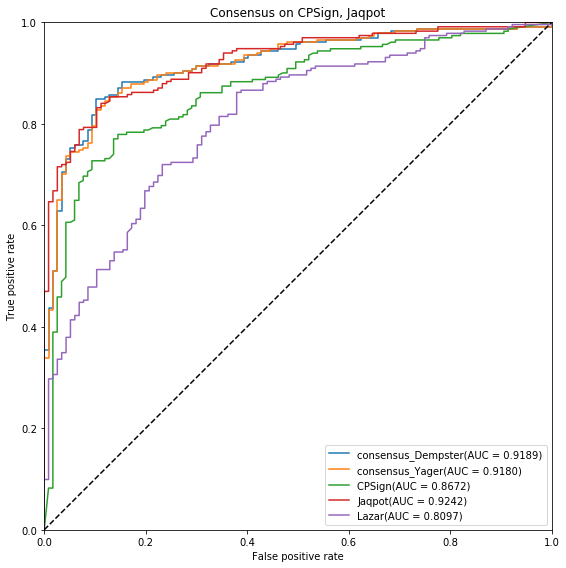

In [117]:
# prepare the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for model in models:
    ax.plot(fpr[model], tpr[model], label=model + '(AUC = %0.4f)' % auc[model])
    
ax.plot([0,1], [0,1], label='', color='black', linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])


ax.set_title('Consensus on CPSign, Jaqpot')

fig.tight_layout()
fig.savefig('model-comparison-roc.png')